# Suy luận nhân quả với dowhy.sampler

## BS. Lê Ngọc Khả Nhi

Đây là bài thực hành thứ 2 nhằm khảo sát một cách chi tiết hơn các tính năng chính của package dowhy áp dụng cho bài toán suy luận nhân quả với can thiệp nhị phân; bao gồm: Sampler (lấy mẫu phân phối xác suất dưới can thiệp), phương pháp ước lượng backdoor.propensity_score_stratification và một số chiến thuật phản nghiệm.

In [2]:
import numpy as np
import pandas as pd

import dowhy.api

import seaborn as sns

from statsmodels.api import OLS

# Tạo dữ liệu mô phỏng


Đầu tiên, Nhi sẽ tạo một dữ liệu mô phỏng một thử nghiệm can thiệp điều trị đơn giản với những giả định như sau:

Mẫu khảo sát gồm có 3000 bệnh nhân : N = 5000

D là một loại thuốc điều trị
Y là một biomarker mà giá trị tỉ lệ với độ nặng của bệnh (Y giảm là một kết cục tốt)

Z là một hằng số sinh lý có ảnh hưởng đến quyết định điều trị, đồng thời Z cũng là một hiệp biến của Y, tức có ảnh hưởng một phần nhỏ đến kết cục Y. 

Ta giả định Z tuân theo quy luật phân phối Gamma có trung bình = 1.5 : z ~ Gamma(mu = 1.5)

Xác suất một bệnh nhân được cho dùng thuốc D (được xếp vào phân nhóm điều trị) hay không (xếp vào Nhóm chứng) phụ thuộc vào giá trị Z theo quy luật giả định:

D ~ Binomial(1, true_propensity), với true_propensity = 1/(1 + np.exp(-0.18 * z))

Giả định giá trị của Y được ước tính bằng một hàm tuyến tính có dạng:

y = 10 + 3.6 * z - 5 * d + sai số ngẫu nhiên

với Sai số ngẫu nhiên = 1.2 * Normal(0,1)

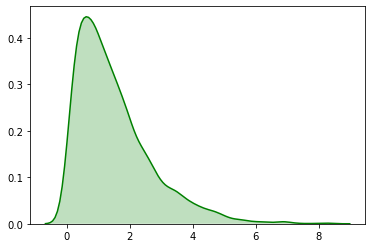

In [10]:
# Mô phỏng Z

N = 3000

z = np.random.gamma(1.5,size=N)

sns.kdeplot(z, shade = True, color = "g")

In [58]:
# Mô phỏng True_propensity và giá trị d

true_propensity = 1/(1 + np.exp(-0.18 * z))

d = np.random.binomial(1, true_propensity)

print(pd.Series(d).value_counts())

1    1725
0    1275
dtype: int64


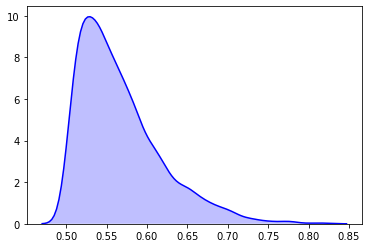

In [59]:
sns.kdeplot(true_propensity, shade = True, color = "b")

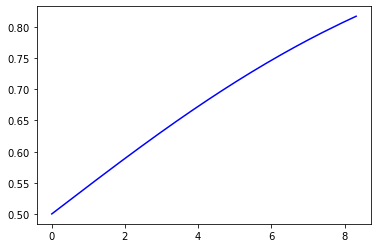

In [60]:
sns.lineplot(z, true_propensity,  
             color = 'b')

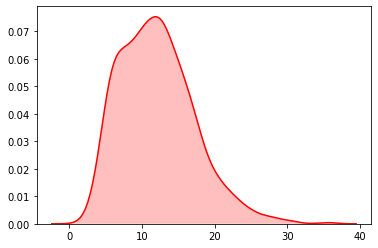

In [30]:
# Mô phỏng giá trị Y

y = 10 + 3.6 * z - 6 * d + 1.2 * np.random.normal(size=N)

sns.kdeplot(y, shade = True, color = 'red')

In [39]:
sum(y<=0) # Đảm bảo Y > 0

0

Đóng gói dữ liệu vào dataframe:

In [17]:
df = pd.DataFrame({'Z': z, 'D': d, 'Y': y})

df

,Z,D,Y
0,4.598115,0,26.468223
1,1.378700,1,7.951724
2,1.738957,0,15.738011
3,0.596754,0,10.964121
4,1.232415,1,8.894808
...,...,...,...
2995,3.135154,1,16.204696
2996,2.472583,0,18.976261
2997,0.509784,0,10.514705
2998,4.410050,0,25.492128


So sánh giá trị Y giữa 2 phân nhóm Điều trị (D= 1) và nhóm chứng (D=0):

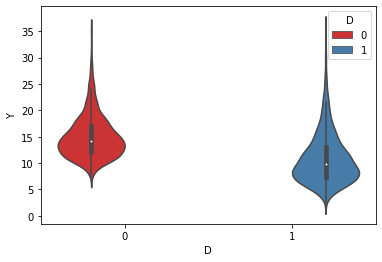

In [38]:
sns.violinplot(data = df,hue = 'D',
                x='D', y='Y', 
                palette="Set1",
                alpha = 0.2)

Xác suất biên và xác suất kết hợp giữa Z,Y theo điều kiện D:

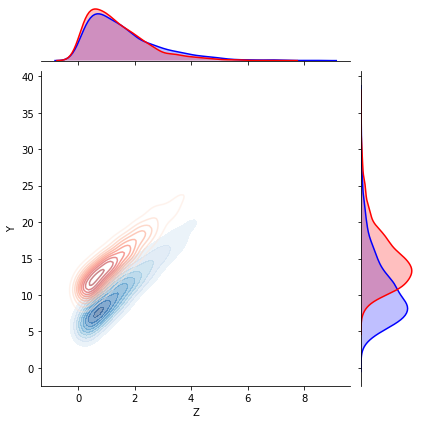

In [49]:
t_df = df.loc[df['D'] == 1]
c_df = df.loc[df['D'] == 0]

g = sns.JointGrid(x="Z", y="Y", data = df)

sns.kdeplot(t_df.Z, t_df.Y, cmap="Blues",
            shade=True, 
            shade_lowest=False, 
            ax=g.ax_joint, linestyles="-",
           alpha = 0.5)

sns.kdeplot(c_df.Z, c_df.Y, cmap="Reds",
            ax=g.ax_joint,
           alpha = 0.5)

sns.kdeplot(t_df.Z, color="b",
            shade=True, 
            legend=False,
            ax=g.ax_marg_x)

sns.kdeplot(c_df.Z, color ="r",
            shade=True,
            legend=False,
            ax=g.ax_marg_x)

sns.kdeplot(t_df.Y, color ="b",
            shade=True, 
            vertical=True,
            legend=False,
            ax=g.ax_marg_y)

sns.kdeplot(c_df.Y, color ="r",
            shade=True, 
            vertical=True,
            legend=False,
            ax=g.ax_marg_y)

Khảo sát hiệu ứng của Z lên Y:

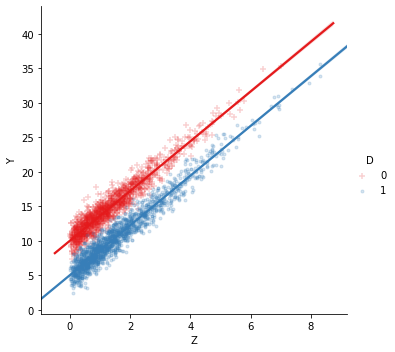

In [50]:
sns.lmplot(data =df, x='Z', y='Y', hue = 'D', 
           markers = ['+','.'], palette="Set1",
          scatter_kws={'alpha':0.2})

Giá trị trung bình của Y ở 2 phân nhóm:

In [52]:
df.groupby('D').mean()['Y']

D
0    14.994559
1    10.873113
Name: Y, dtype: float64

Khác biệt giữa 2 trung bình này:

In [54]:
eff = lambda df,d: (df[df.D == d].mean())['Y']

eff(df,1) - eff(df,0)

# Thiết lập mô hình nhân quả 

Dựa vào giả thuyết ban đầu của thí nghiệm, ta dựng một causal diagram với cú pháp digraph

In [55]:
dg = 'digraph {U[label="Unobs Conf"]; U->D; U->Y; D->Y; Z-> Y; Z->D;}'

print(dg)

digraph {U[label="Unobs Conf"]; U->D; U->Y; D->Y; Z-> Y; Z->D;}


Ghi chú: U = Unobserved confounder; D = treatment, Y =Outcome, Z = Observed confounder

Tiếp theo, ta đóng gói mô hình bằng hàm CausalModel của dowhy, gồm dataframe, biến treatment D, biến outcome Y và causal diagram dg

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. DLL load failed: %1 n’est pas une application Win32 valide.
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['D'] on outcome ['Y']
INFO:dowhy.causal_graph:Using Matplotlib for plotting
C:\Users\bacsi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\bacsi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


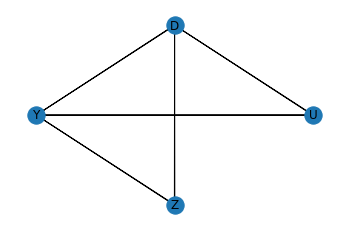

In [87]:
from dowhy import CausalModel

model = CausalModel(df, 
                    treatment = ['D'],
                    outcome = ['Y'],
                    graph = dg)

model.view_model()

# Lấy mẫu phân phối kết quả theo điều kiện can thiệp dùng do.sampler

Trong bài này, Nhi sẽ thử dùng một tính năng độc đáo của dowhy, đó là module do.sampler; 
Công cụ này cho phép sử dụng phương pháp bootstrap để lấy mẫu phân phối của biến kết cục Y dưới điều kiện Có hoặc không có Can thiệp: Y|do(D=1) và Y|do(D=0), có áp dụng trọng số (weights) cho từng trường hợp dựa vào phân phối propensity score của D (được ước tính bằng một mô hình D ~ f(Z)).

Ghi chú: Hàm WeightingSampler tạo ra 1 sampler, với dữ liệu đầu vào df, mô hình Causalmodel ta đã tạo ra, tùy chỉnh keep_original_treatment=False cho phép tùy ý thiết lập điều kiện can thiệp D=0 hay D=1 trong quá trình chọn mẫu, không lệ thuộc vào phân bố thực của D trong dữ liệu quan sát. Cuối cùng: variable_types khai báo kiểu biến: b = binary, c = continuous.

In [61]:
from dowhy.do_samplers.weighting_sampler import WeightingSampler

sampler = WeightingSampler(df,
                           causal_model=model,
                           keep_original_treatment=False,
                           variable_types={'D': 'b', 'Z': 'c', 'Y': 'c'})

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Z', 'U']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


Ta bắt đầu lấy mẫu 3000 quan sát dưới 2 điều kiện, Kết quả chính là phân bố của Y dưới điều kiện can thiệp Y|do(D=1) và Y|do(D=0)

In [64]:
cdf_1 = sampler.do_sample(x = {'D':1})

cdf_1.head()

,Z,D,Y,propensity_score,weight
0,0.909691,1,8.775068,0.536574,1.863677
1,3.839982,1,19.322406,0.658642,1.518275
2,1.332000,1,9.387776,0.554818,1.802393
3,0.933646,1,8.089726,0.537612,1.860079
4,0.863257,1,7.615138,0.534561,1.870695


In [65]:
cdf_0 = sampler.do_sample(x = {'D':0})

cdf_0.head()

,Z,D,Y,propensity_score,weight
0,1.666920,0,15.629451,0.430815,2.321182
1,0.881491,0,11.631583,0.464649,2.152164
2,0.950548,0,13.481859,0.461656,2.166114
3,1.468286,0,13.548700,0.439323,2.276228
4,0.244738,0,9.632440,0.492334,2.031144


Kết quả là 1 dataframe với cấu trúc như dữ liệu gốc, nhưng có thêm 2 cột propensity score (hằng định) và weight

In [70]:
cdf = pd.concat([cdf_0, cdf_1])

cdf.head()

,Z,D,Y,propensity_score,weight
0,1.666920,0,15.629451,0.430815,2.321182
1,0.881491,0,11.631583,0.464649,2.152164
2,0.950548,0,13.481859,0.461656,2.166114
3,1.468286,0,13.548700,0.439323,2.276228
4,0.244738,0,9.632440,0.492334,2.031144


Với kết quả lấy mẫu này, ta có thể khảo sát phân bố của hiệu ứng nhân quả (điều trị), là khác biệt giữa Y|do(D=1) và Y|do(D=0); cũng như phân bố xác suất kết hợp của các hiệp biến (Z) hay outcome Y trong thí nghiệm.

C:\Users\bacsi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\bacsi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


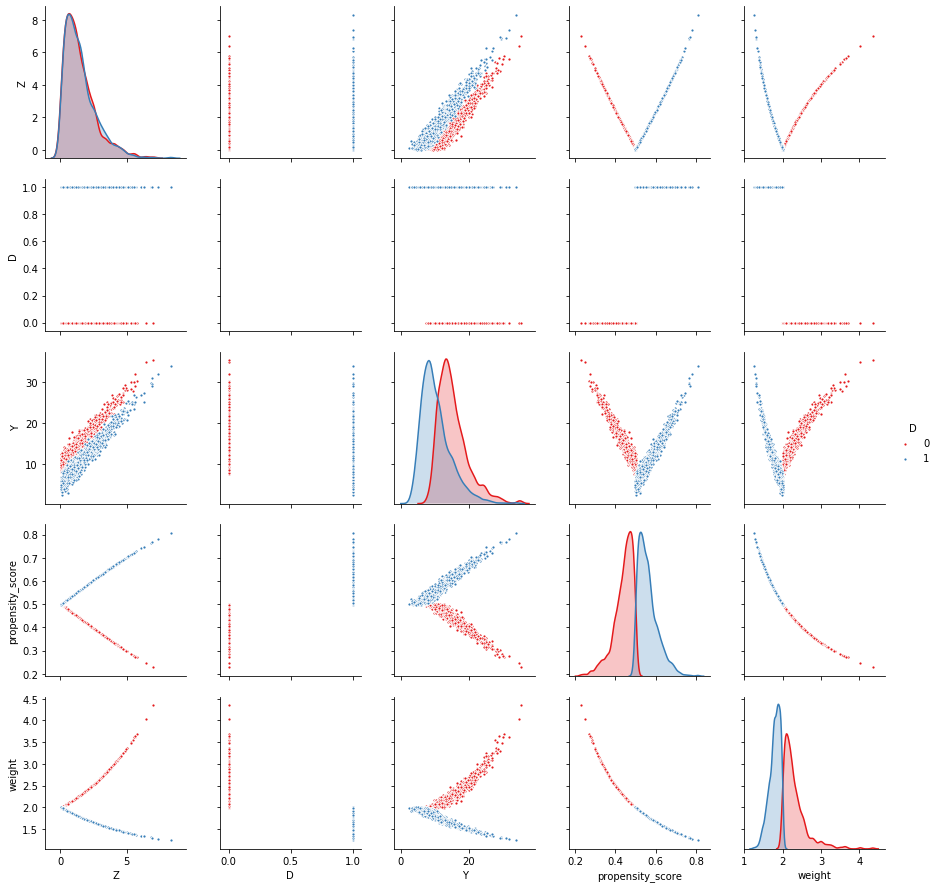

In [73]:
g = sns.pairplot(cdf,
             hue = 'D',
             diag_kind = "kde",
                markers=".",
                 diag_kws= {'shade': True},
                palette = 'Set1')

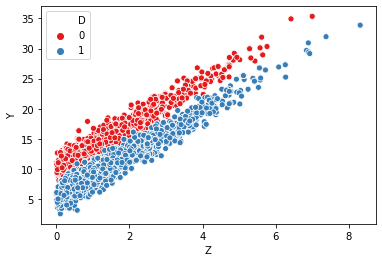

In [75]:
sns.scatterplot(data = cdf, x ='Z', y = 'Y', 
                hue = 'D',palette = 'Set1'
               )

Phân phối của Y|do(D=1) và Y|do(D=0)

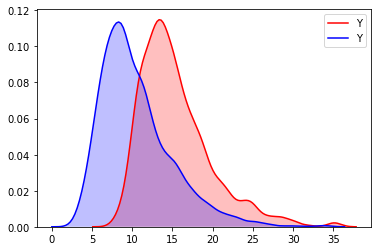

In [78]:
sns.kdeplot(cdf_0.Y, shade = True, color = "red")
sns.kdeplot(cdf_1.Y, shade = True, color = 'blue')

Phân phối của hiệu ứng can thiệp (Causal effect), giá trị trung bình  = -4.915

-4.914738301908307


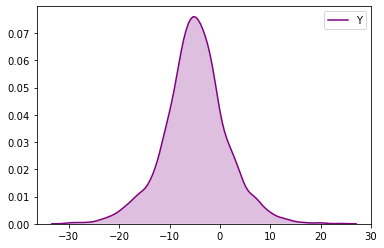

In [81]:
effect = cdf_1.Y - cdf_0.Y

print(effect.mean())

sns.kdeplot(effect, shade = True, color = 'purple')

# So sánh với phương pháp backdoor.propensity_score_stratification

Một phương pháp ước lượng causal effect cho trường hợp treatment là binary variable, đó là backdoor.propensity_score_stratification. Nguyên lý của phương pháp này đó là: Sử dụng 1 mô hình logistic (hay 1 algorithm classifier nào đó) để ước tính propensity score (xác suất của 1 bệnh nhân được phân vào nhóm Treatment hay Placebo), mô hình này không cần chính xác); sau đó dùng K-mean clustering để phân cụm bệnh nhân theo propensity scores, ước tính causal effect cho mỗi phân nhóm nhỏ này rồi lấy trung bình.

Ta đối chiếu kết quả phương pháp tái chọn mẫu bootstrap vừa làm ở trên và phương pháp backdoor.propensity_score_stratification

In [108]:
df['D'] = df['D'].astype('bool')

In [110]:
model = CausalModel(df, 
                    treatment = ['D'],
                    outcome = ['Y'],
                    graph = dg)

identified_estimand = model.identify_effect()

print(identified_estimand)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. DLL load failed: %1 n’est pas une application Win32 valide.
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['D'] on outcome ['Y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Z', 'U']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|Z))
dD                  
Estimand assumption 1, Unconfoundedness: If U→D and U→Y then P(Y|D,Z,U) = P(Y|D,Z)
### Estimand : 2
Estimand name: iv
No such variable found!



In [111]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="ate")
print(causal_estimate_strat)

print("Hiệu ứng điều trị = " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Y~D+Z


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|Z))
dD                  
Estimand assumption 1, Unconfoundedness: If U→D and U→Y then P(Y|D,Z,U) = P(Y|D,Z)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~D+Z
## Estimate
Value: -4.976251820918458

Hiệu ứng điều trị = -4.976251820918458


C:\Users\bacsi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kết quả của backdoor.propensity_score_stratification cho ra tương đương với causal effect = -4.976

# Củng cố kết quả bằng Phản nghiệm

Ngoài việc ước tính Causal effect, dowhy còn cho phép ta củng cố kết luận bằng phương pháp Phản nghiệm, với nhiều chiến thuật khác nhau:

Thí dụ, Ta có thể đưa thêm vào dữ liệu 1 biến gây nhiễu Common_cause (Z') với phân phối ngẫu nhiên (hiệu ứng cực thấp lên D và Y). Kết quả kì vọng là Causal effect không thay đổi:

In [112]:
res_random=model.refute_estimate(identified_estimand, 
                                 causal_estimate_strat, 
                                 method_name="random_common_cause")

print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Y~D+Z+w_random


Refute: Add a Random Common Cause
Estimated effect:(-4.976251820918458,)
New effect:(-4.962687462041885,)



C:\Users\bacsi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Quả thực, kết quả mới = -4.962, không thay đổi.

Một chiến thuật phản nghiệm khác, đó là giảm sample size, hay loại bỏ ngẫu nhiên 1 tỉ lệ lớn quan sát khỏi dữ liệu; kết quả kì vọng là causal effect không thay đổi (Lưu ý: Causal diagram không phụ thuộc vào dữ liệu, mô hình đúng sẽ luôn đúng dù có bao nhiêu dữ liệu).

In [120]:
res_subset=model.refute_estimate(identified_estimand, 
                                 causal_estimate_strat,
                                 method_name="data_subset_refuter", 
                                 subset_fraction=0.5)

print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Y~D+Z


Refute: Use a subset of data
Estimated effect:(-4.976251820918458,)
New effect:(-4.954517539247523,)



C:\Users\bacsi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kết quả causal effect trên 50% dữ liệu vẫn không thay đổi = -4.954

Một chiến thuật khác để phản nghiệm, là Placebo refuting, hay cưỡng bức D = 0, giữ nguyên giá trị confounder Z (permutation) và cấu trúc causal diagram. Kết quả kì vọng là causal effect của Placebo rất gần 0.

In [122]:
res_placebo=model.refute_estimate(identified_estimand, 
                                  causal_estimate_strat,
                                  method_name="placebo_treatment_refuter", 
                                  placebo_type='permute')
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Y~placebo+Z


Refute: Use a Placebo Treatment
Estimated effect:(-4.976251820918458,)
New effect:(-0.003230558718688247,)



C:\Users\bacsi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
